# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

## Exercises

**Exercise 9-1:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [2]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [3]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [4]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [5]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [6]:
# Solution goes here
def Tests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
    
    # DiffMeansPermute
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    pvalueDMP1 = ht.PValue(iters=iters)

    data = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
    ht = DiffMeansPermute(data)
    pvalueDMP2 = ht.PValue(iters=iters)
    
    # CorrelationPermute
    cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
    ht = CorrelationPermute(data)
    pvalueCP = ht.PValue(iters=iters)

    # PregLengthTest
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    pvaluePLT = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, pvalueDMP1, pvalueDMP2, pvalueCP, pvaluePLT))

In [7]:
# Solution goes here
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    Tests(sample)
    n //= 2

9148	0.15	0.00	0.00	0.00
4574	0.55	0.00	0.00	0.00
2287	0.46	0.02	0.00	0.03
1143	0.36	0.14	0.02	0.01
571	0.88	0.11	0.04	0.03
285	0.03	0.42	0.77	0.67
142	0.43	0.38	0.72	0.49


In [8]:
# Solution goes here

**Exercise 10-1:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [9]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [10]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

Estimate intercept and slope.

In [11]:
# Solution goes here
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918104, 0.005281454169417819)

Make a scatter plot of the data and show the fitted line.

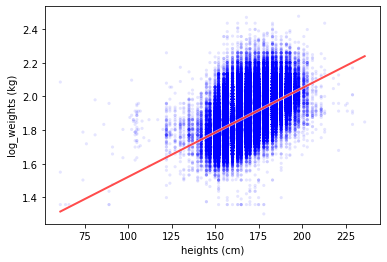

In [12]:
# Solution goes here
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights (cm)",
                 ylabel='log_weights (kg)',
                 legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

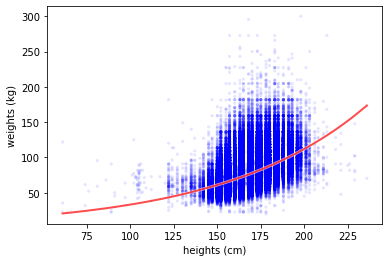

In [13]:
# Solution goes here
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)

thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10**fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="heights (cm)",
                 ylabel='weights (kg)',
                 legend=False)

Plot percentiles of the residuals.

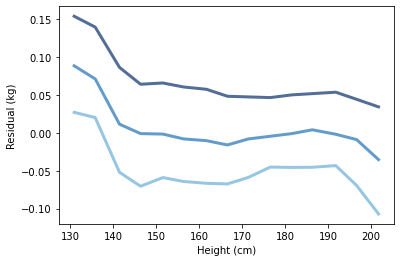

In [14]:
# Solution goes here
df['residual'] = thinkstats2.Residuals(heights, log_weights, inter, slope)

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

ht_means = [group.htm3.mean() for i, group in groups][1:-1]

cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(ht_means, weight_percentiles, label=label)
    
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Residual (kg)')

Compute correlation.

In [15]:
# Solution goes here
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983443

Compute coefficient of determination.

In [16]:
# Solution goes here
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311894065

Confirm that $R^2 = \rho^2$.

In [17]:
# Solution goes here
print('rho', rho)
print('R', np.sqrt(r2))

rho 0.5317282605983443
R 0.5317282605983442


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [18]:
# Solution goes here
print('Std(ys)', thinkstats2.Std(log_weights))

Std(ys) 0.103207250300049


Compute Std(res), the RMSE of predictions that do use height.

In [19]:
# Solution goes here
print('Std(res)', thinkstats2.Std(res))

Std(res) 0.0874077708041609


How much does height information reduce RMSE?

In [20]:
# Solution goes here
1 - thinkstats2.Std(res) / thinkstats2.Std(log_weights)

0.15308497658793452

Use resampling to compute sampling distributions for inter and slope.

In [21]:
# Solution goes here
t = []
iters = 100
for _ in range(iters):
    sample = thinkstats2.ResampleRows(df)
    heights = sample.htm3
    log_weights = np.log10(sample.wtkg2)
    estimates = thinkstats2.LeastSquares(heights, log_weights)
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

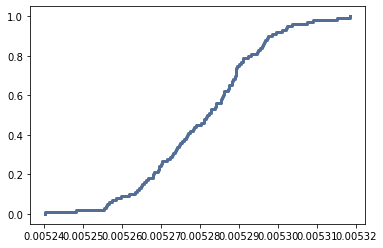

In [22]:
# Solution goes here
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [23]:
# Solution goes here
print('pvalue', cdf[0])

pvalue 0


In [24]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Compute the 90% confidence interval of slope.

In [25]:
# Solution goes here
print(cdf.ConfidenceInterval(90))

(0.005256058108647525, 0.005302420790742356)


Compute the mean of the sampling distribution.

In [26]:
# Solution goes here
print('mean', thinkstats2.Mean(slopes))

mean 0.005280933395440209


Compute the standard deviation of the sampling distribution, which is the standard error.

In [27]:
# Solution goes here
print('stderr', thinkstats2.Std(slopes))

stderr 1.4578162267076007e-05


Resample rows without weights, compute mean height, and summarize results.

In [28]:
# Solution goes here
estimates = [thinkstats2.ResampleRows(df).htm3.mean() 
                        for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 168.9561233048364 0.01698023920640673 (168.92961155237575, 168.98156541158875)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [29]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [30]:
# Solution goes here
estimates = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() 
                      for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 170.4967059510095 0.018160292082237607 (170.4665817821702, 170.5307756826128)
